## Set up

##### Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras

from keras.layers import Dense, MaxPooling2D, Conv2D, Flatten
from keras.models import Sequential
from keras.losses import SparseCategoricalCrossentropy
from keras.optimizers import RMSprop
from keras.utils import image_dataset_from_directory

from sklearn.metrics import confusion_matrix, accuracy_score

import numpy as np
import matplotlib.pyplot as plt

2023-11-17 23:41:43.055038: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


##### Data 

In [5]:
# Specify the path to your image dataset
dataset_training_path = "/home/layth/git/mri_analysis/archive/Training/"
dataset_testing_path = "/home/layth/git/mri_analysis/archive/Testing/"

dataset_training_path = "/Users/studentuser/WORKING_BASE/mri_analysis/archive/Training"
dataset_testing_path = "/Users/studentuser/WORKING_BASE/mri_analysis/archive/Testing"

RESIZE = 150
FLAT = RESIZE * RESIZE * 3

In [6]:
# image_size: resizes the images
# batch_size: how many images at a time
# subset: allows me to return a tuple (train_data, val_data)
train_data = image_dataset_from_directory(directory=dataset_training_path,
                                          image_size=(RESIZE, RESIZE),
                                          batch_size=32,
                                          color_mode='rgb',
                                          seed=42)

testing_data = image_dataset_from_directory(directory=dataset_testing_path,
                                          image_size=(RESIZE, RESIZE),
                                          batch_size=32,
                                          color_mode='rgb',
                                          seed=42)


X_train = []
y_train = []
X_test = []
y_test = []

# train_data yields batches. I am 'melting' 
# all batches together in one big array
for images, labels in train_data:
  X_train.extend(images.numpy())
  y_train.extend(labels.numpy())
  
for images, labels in testing_data:
  X_test.extend(images.numpy())
  y_test.extend(labels.numpy())

X_train = np.array(X_train) # convert X_train to numpy array
X_train = np.divide(X_train, 255) # rescale pixels
X_train_flat = X_train.reshape((np.shape(X_train)[0], -1)) # flatten
y_train = np.array(y_train)

X_test = np.array(X_test) # convert X_val to numpy array
X_test = np.divide(X_test, 255) # rescale pixels
X_test_flat = X_test.reshape((np.shape(X_test)[0], -1)) # flatten
y_test = np.array(y_test)

print()
print(f"Flattening after resize: {RESIZE} * {RESIZE} * 3 = {FLAT}")
print(f"Shape of X_train: {np.shape(X_train)}")
print(f"Shape of X_train_flat: {np.shape(X_train_flat)}")
print(f"Shape of y_train: {np.shape(y_train)}")
print(f"Shape of X_test: {np.shape(X_test)}")
print(f"Shape of X_test_flat: {np.shape(X_test_flat)}")
print(f"Shape of y_val: {np.shape(y_test)}")

Found 2870 files belonging to 4 classes.
Found 394 files belonging to 4 classes.

Flattening after resize: 150 * 150 * 3 = 67500
Shape of X_train: (2870, 150, 150, 3)
Shape of X_train_flat: (2870, 67500)
Shape of y_train: (2870,)
Shape of X_test: (394, 150, 150, 3)
Shape of X_test_flat: (394, 67500)
Shape of y_val: (394,)


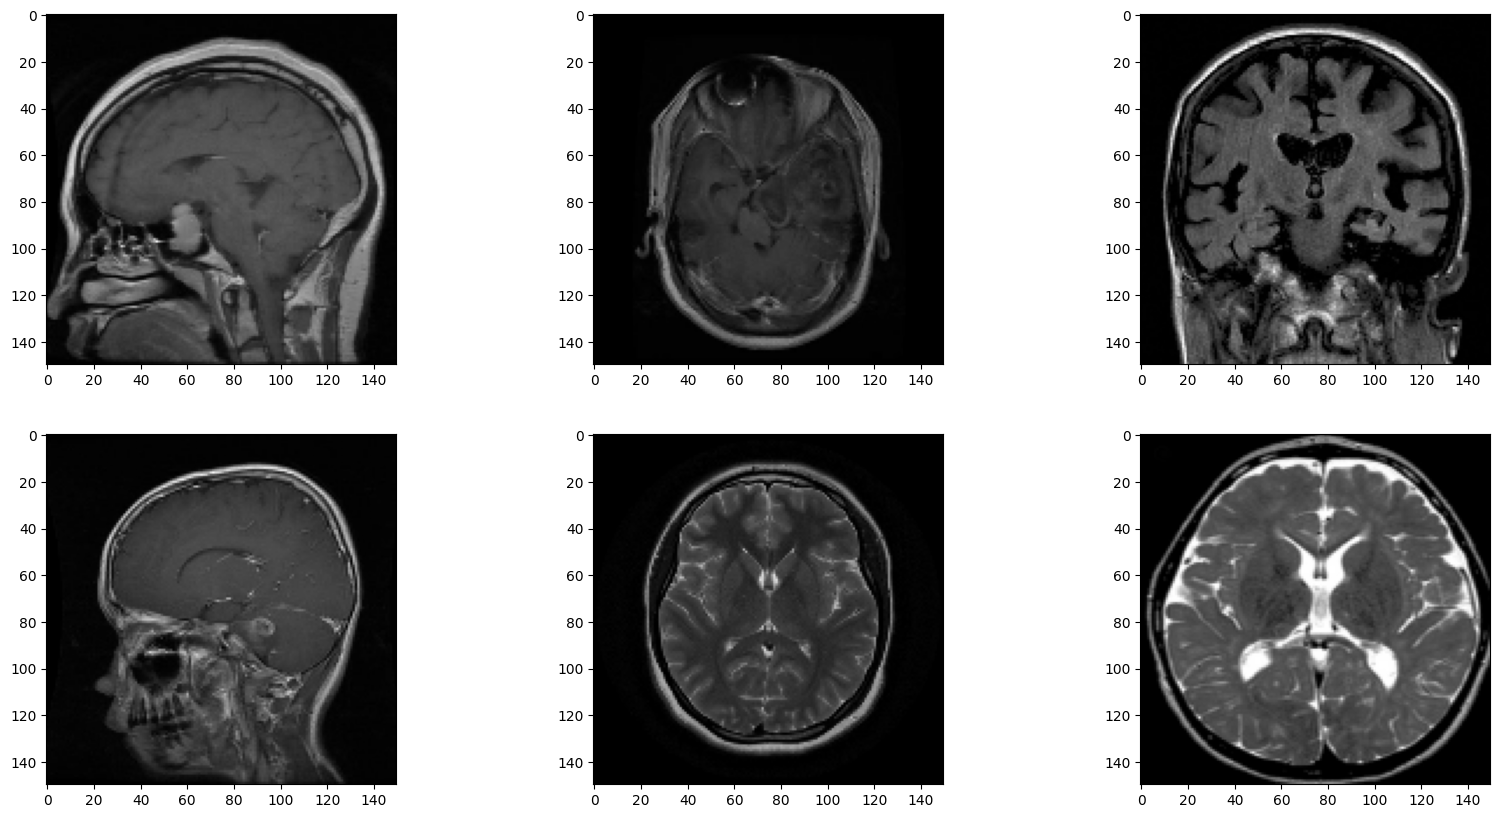

In [5]:
_, axes = plt.subplots(2, 3, figsize=(20,10))

axes[0,0].imshow(X_train[0])
axes[0,1].imshow(X_train[1])
axes[0,2].imshow(X_train[2])

axes[1,0].imshow(X_train[3])
axes[1,1].imshow(X_train[4])
axes[1,2].imshow(X_train[5])

plt.show()

##### helper functions and classes

In [7]:
class myCallback(tf.keras.callbacks.Callback):
    def __init__(self, target_accuracy):
        self.target_accuracy = target_accuracy
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') is not None and logs.get('accuracy') > self.target_accuracy:
            print(f"\nReached {self.target_accuracy * 100}% accuracy so cancelling training!")
            self.model.stop_training = True    

In [8]:
def graph_accuracy_and_loss(history):
  # list all data in history
  # print(history.history.keys())
  
  _, axes = plt.subplots(1, 2, figsize=(20,10))
  
  # summarize history for accuracy
  axes[0].plot(history.history['accuracy'])
  axes[0].plot(history.history['val_accuracy'])
  axes[0].set_title('model accuracy')
  axes[0].set_ylabel('accuracy')
  axes[0].set_xlabel('epoch')
  axes[0].legend(['train', 'test'], loc='upper left')
  
  # summarize history for loss
  axes[1].plot(history.history['loss'])
  axes[1].plot(history.history['val_loss'])
  axes[1].set_title('model loss')
  axes[1].set_ylabel('loss')
  axes[1].set_xlabel('epoch')
  axes[1].legend(['train', 'test'], loc='upper left')
  
  plt.show()
  
  return None

In [9]:
def model_accuracy_and_confusion_matrix(model, Xtrain, ytrain, Xtest, ytest):
  ypred_train        = model.predict(Xtrain)
  ypred_train        = np.argmax(ypred_train, axis=1)
  accuracy_train     = accuracy_score(ytrain, ypred_train)
  conf_matrix_train  = confusion_matrix(ytrain, ypred_train)
  print(f'Accuracy for training data (R^2): {accuracy_train} \n')
  print('Confusion matrix for training data:\n', conf_matrix_train, '\n')

  ypred_test         = model.predict(Xtest)
  ypred_test         = np.argmax(ypred_test, axis=1)
  accuracy_train     = accuracy_score(ytest, ypred_test)
  conf_matrix_train  = confusion_matrix(ytest, ypred_test)
  print(f'Accuracy for testing data (R^2): {accuracy_train} \n')
  print('Confusion matrix for testing data:\n', conf_matrix_train, '\n')
  return None

## ANN

In [17]:
a_model = Sequential(
  [
    Dense(units=128, activation='relu', input_shape=(FLAT,), name='L0'),
    Dense(units=64, activation='relu', name='L1'),
    Dense(units=32, activation='relu', name='L2'),
    Dense(units=4, activation='linear', name='L3')
  ]
)

a_model.compile(optimizer=RMSprop(learning_rate=0.001),
                loss=SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

a_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 L0 (Dense)                  (None, 128)               8640128   
                                                                 
 L1 (Dense)                  (None, 64)                8256      
                                                                 
 L2 (Dense)                  (None, 32)                2080      
                                                                 
 L3 (Dense)                  (None, 4)                 132       
                                                                 
Total params: 8650596 (33.00 MB)
Trainable params: 8650596 (33.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
EPOCHS=100 # epochs = iterations
BATCH_SIZE=32
TARGET_ACC=0.95
callbacks = myCallback(target_accuracy=TARGET_ACC)
a_history = a_model.fit(X_train_flat, y_train,
                        validation_split=.15,
                        callbacks=[callbacks],
                        epochs=EPOCHS, 
                        batch_size=BATCH_SIZE,
                        verbose=1)

print(f"\nYour model reached the desired accuracy of after {len(a_history.epoch)} epochs")

Epoch 1/100
77/77 [==============================] - 8s 91ms/step - loss: 3.7166 - accuracy: 0.3961 - val_loss: 1.3904 - val_accuracy: 0.4107
Epoch 2/100
77/77 [==============================] - 6s 78ms/step - loss: 1.5452 - accuracy: 0.4539 - val_loss: 2.3461 - val_accuracy: 0.2854
Epoch 3/100
77/77 [==============================] - 6s 73ms/step - loss: 1.1583 - accuracy: 0.5326 - val_loss: 1.6638 - val_accuracy: 0.4524
Epoch 4/100
77/77 [==============================] - 6s 74ms/step - loss: 1.0380 - accuracy: 0.5662 - val_loss: 1.0347 - val_accuracy: 0.6009
Epoch 5/100
77/77 [==============================] - 6s 74ms/step - loss: 0.9133 - accuracy: 0.6080 - val_loss: 1.5178 - val_accuracy: 0.4107
Epoch 6/100
77/77 [==============================] - 6s 73ms/step - loss: 0.8398 - accuracy: 0.6417 - val_loss: 1.0250 - val_accuracy: 0.6195
Epoch 7/100
77/77 [==============================] - 6s 73ms/step - loss: 0.7614 - accuracy: 0.6671 - val_loss: 1.0572 - val_accuracy: 0.6218
Epoch 

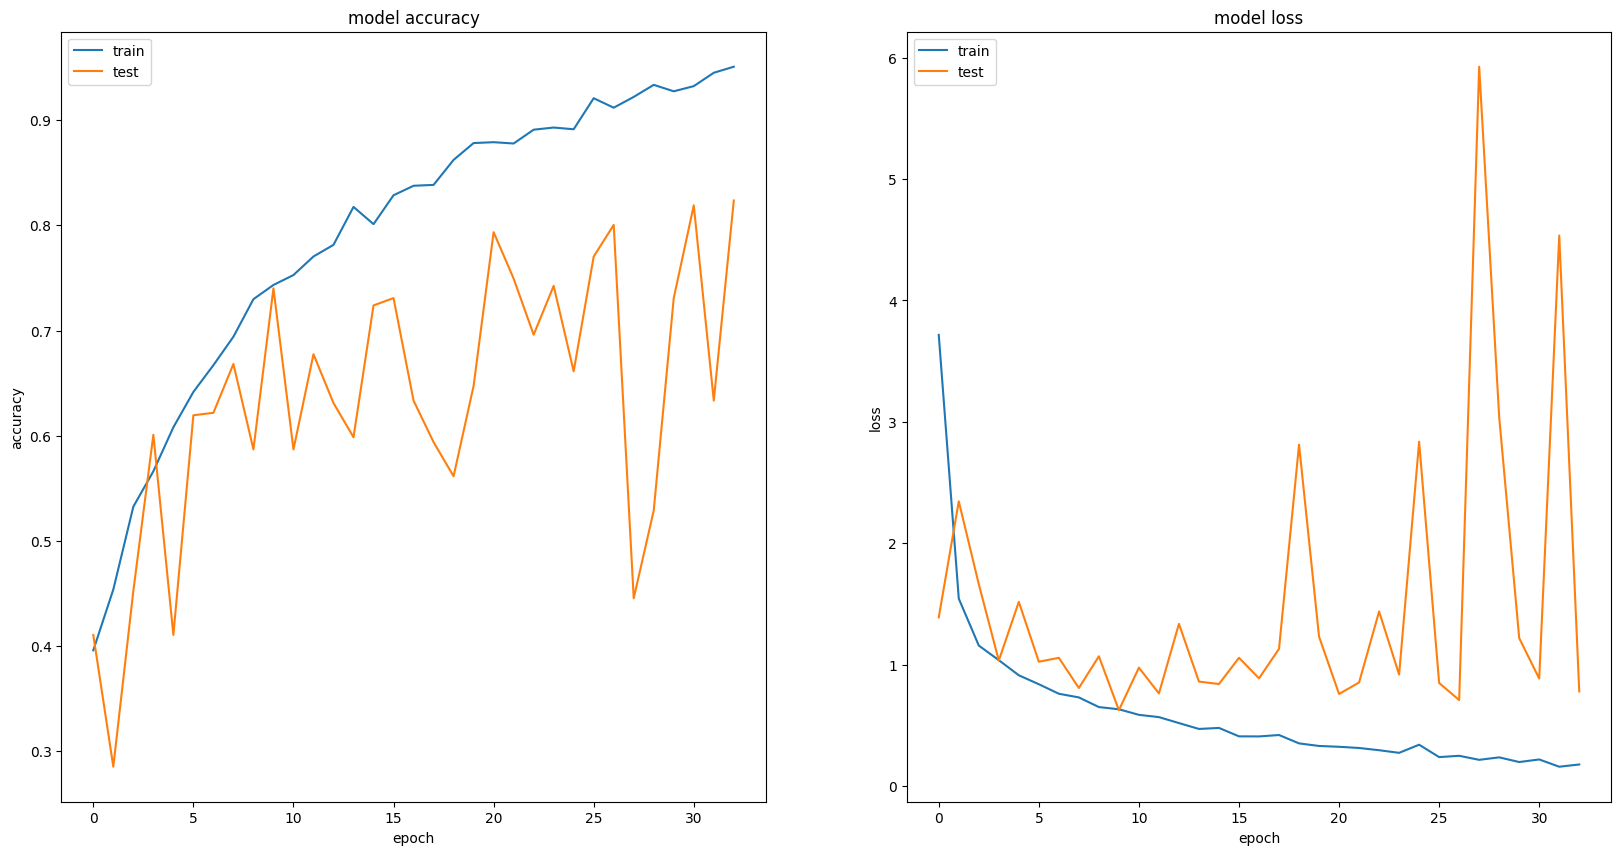

90/90 [==============================] - 1s 7ms/step
Accuracy for training data (R^2): 0.9581881533101045 

Confusion matrix for training data:
 [[764  56   5   1]
 [ 14 777  27   4]
 [  0   6 386   3]
 [  0   2   2 823]] 

13/13 [==============================] - 0s 6ms/step
Accuracy for testing data (R^2): 0.6548223350253807 

Confusion matrix for testing data:
 [[ 21  16  56   7]
 [  3  96  15   1]
 [  0   5 100   0]
 [  0  26   7  41]] 


In [11]:
graph_accuracy_and_loss(history=a_history)
model_accuracy_and_confusion_matrix(a_model, X_train_flat, y_train, X_test_flat, y_test)

While training accuracy is good, this model fails to generalize to the testing data

## CNN

In [18]:
c_model = Sequential(
  [
    Conv2D(filters=16, kernel_size=(3,3), 
           activation='relu', input_shape=(RESIZE,RESIZE,3,), name="L0"),
    MaxPooling2D(pool_size=2, strides=2, name="L1"),
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', name="L2"),
    MaxPooling2D(pool_size=2, strides=2, name="L3"),
    Conv2D(64, (3,3), activation='relu', name="L4"),
    MaxPooling2D(pool_size=2, strides=2, name="L5"),
    Flatten(name="L6"),
    Dense(units=512, activation='relu', name="L7"),
    Dense(units=4, activation='linear', name="L8"),
  ]
)

c_model.compile(optimizer=RMSprop(learning_rate=0.001),
                loss=SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

c_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 L0 (Conv2D)                 (None, 148, 148, 16)      448       
                                                                 
 L1 (MaxPooling2D)           (None, 74, 74, 16)        0         
                                                                 
 L2 (Conv2D)                 (None, 72, 72, 32)        4640      
                                                                 
 L3 (MaxPooling2D)           (None, 36, 36, 32)        0         
                                                                 
 L4 (Conv2D)                 (None, 34, 34, 64)        18496     
                                                                 
 L5 (MaxPooling2D)           (None, 17, 17, 64)        0         
                                                                 
 L6 (Flatten)                (None, 18496)            

In [19]:
EPOCHS=100 # epochs = iterations
BATCH_SIZE=16
TARGET_ACC=0.95
callbacks = myCallback(target_accuracy=TARGET_ACC)
c_history = c_model.fit(X_train, y_train,
                      validation_split=.15,
                      callbacks=[callbacks],
                      epochs=EPOCHS, 
                      batch_size=BATCH_SIZE,
                      verbose=1)

print(f"\nYour model reached the desired accuracy after {len(c_history.epoch)} epochs")

Epoch 1/100
153/153 [==============================] - 22s 142ms/step - loss: 0.9879 - accuracy: 0.5826 - val_loss: 0.7005 - val_accuracy: 0.7007
Epoch 2/100
153/153 [==============================] - 21s 138ms/step - loss: 0.5553 - accuracy: 0.7737 - val_loss: 0.6686 - val_accuracy: 0.7146
Epoch 3/100
153/153 [==============================] - 21s 138ms/step - loss: 0.3406 - accuracy: 0.8676 - val_loss: 0.4765 - val_accuracy: 0.8121
Epoch 4/100
153/153 [==============================] - 21s 136ms/step - loss: 0.2094 - accuracy: 0.9217 - val_loss: 0.5289 - val_accuracy: 0.7889
Epoch 5/100
153/153 [==============================] - ETA: 0s - loss: 0.1251 - accuracy: 0.9582
Reached 95.0% accuracy so cancelling training!
153/153 [==============================] - 21s 136ms/step - loss: 0.1251 - accuracy: 0.9582 - val_loss: 0.3151 - val_accuracy: 0.9049

Your model reached the desired accuracy after 5 epochs


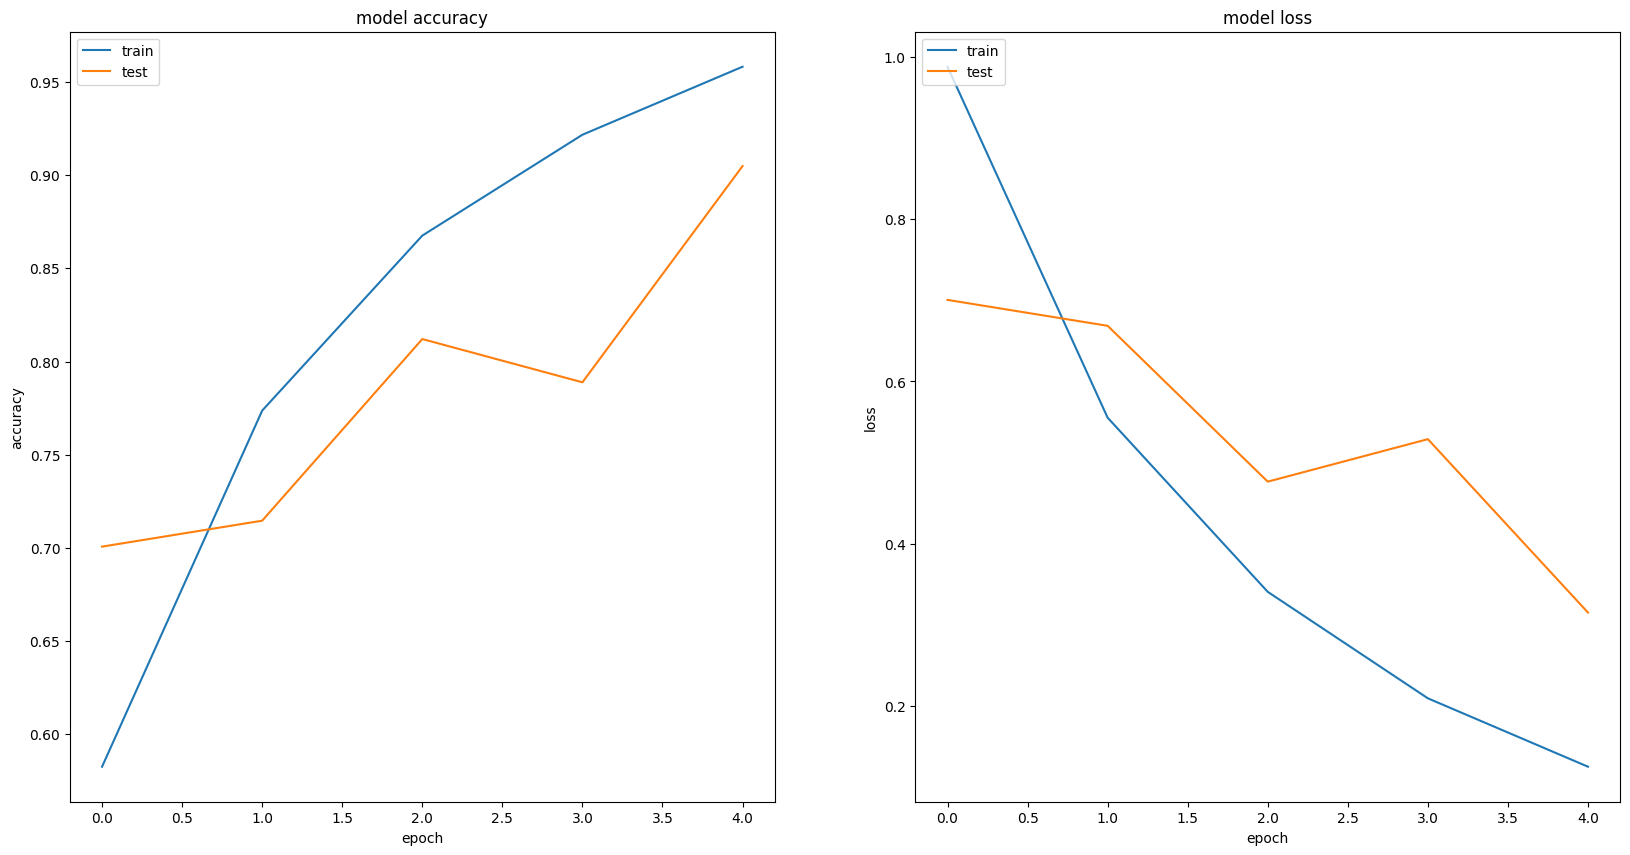

90/90 [==============================] - 5s 52ms/step
Accuracy for training data (R^2): 0.9745644599303136 

Confusion matrix for training data:
 [[807  16   3   0]
 [ 10 781  22   9]
 [  2   6 384   3]
 [  0   1   1 825]] 

13/13 [==============================] - 2s 175ms/step
Accuracy for testing data (R^2): 0.7233502538071066 

Confusion matrix for testing data:
 [[ 17  33  45   5]
 [  0 104  10   1]
 [  2   2 101   0]
 [  2   1   8  63]] 


In [20]:
graph_accuracy_and_loss(history=c_history)
model_accuracy_and_confusion_matrix(c_model, X_train, y_train, X_test, y_test)

A pure CNN model outperforms the ANN model by 7%. We still do not want the training data to reach 99.9 because it would start overfitting.

## ANN-2

In [12]:
a2_model = Sequential(
  [
    Dense(units=4096, activation='relu',input_shape=(FLAT,), name='L0'),
    Dense(units=512, activation='relu', name='l1'), 
    Dense(units=64, activation='relu', name='L2'),
    Dense(units=4, activation='linear', name='L3')
  ]
)

a2_model.compile(optimizer=RMSprop(learning_rate=0.001),
                loss=SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

a2_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 L0 (Dense)                  (None, 4096)              276484096 
                                                                 
 l1 (Dense)                  (None, 512)               2097664   
                                                                 
 L2 (Dense)                  (None, 64)                32832     
                                                                 
 L3 (Dense)                  (None, 4)                 260       
                                                                 
Total params: 278,614,852
Trainable params: 278,614,852
Non-trainable params: 0
_________________________________________________________________


In [13]:
EPOCHS=100 # epochs = iterations
BATCH_SIZE=32
TARGET_ACC=0.95
callbacks = myCallback(target_accuracy=TARGET_ACC)
a2_history = a2_model.fit(X_train_flat, y_train,
                        validation_split=.15,
                        callbacks=[callbacks],
                        epochs=EPOCHS, 
                        batch_size=BATCH_SIZE,
                        verbose=1)

print(f"\nYour model reached the desired accuracy of after {len(a2_history.epoch)} epochs")

Epoch 1/100
77/77 [==============================] - 221s 3s/step - loss: 20.3784 - accuracy: 0.3112 - val_loss: 1.4431 - val_accuracy: 0.3155
Epoch 2/100
77/77 [==============================] - 217s 3s/step - loss: 1.4762 - accuracy: 0.3928 - val_loss: 1.1561 - val_accuracy: 0.5452
Epoch 3/100
21/77 [=======>......................] - ETA: 2:33 - loss: 1.3319 - accuracy: 0.4107

KeyboardInterrupt: 

## Mixed

In [15]:
m_model = Sequential(
  [
    Dense(units=128, activation='relu', input_shape=(FLAT,), name='L0'),
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', name="L2"),
    MaxPooling2D(pool_size=2, strides=2, name="L3"),
    Dense(units=64, activation='relu', name='L1'),
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', name="L2"),
    MaxPooling2D(pool_size=2, strides=2, name="L3"),
    Dense(units=32, activation='relu', name='L2'),
    Dense(units=4, activation='linear', name='L3')
  ]
)

m_model.compile(optimizer=RMSprop(learning_rate=0.001),
                loss=SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

m_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 L0 (Dense)                  (None, 128)               8640128   
                                                                 
 L1 (Dense)                  (None, 64)                8256      
                                                                 
 L2 (Dense)                  (None, 32)                2080      
                                                                 
 L3 (Dense)                  (None, 4)                 132       
                                                                 
Total params: 8,650,596
Trainable params: 8,650,596
Non-trainable params: 0
_________________________________________________________________
